In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import numpy as np

In [2]:
df = pd.read_csv("Pairwise Cluster Comparisons - FINAL.txt", sep="\t")

In [3]:
pos13_16_matches = []

for fam_col in [col for col in df.columns if col.startswith("Family_")]:
    fam_homo = df[df[fam_col] == "Yes"]

    same_13_16 = (fam_homo["Pos13_16_1"] == fam_homo["Pos13_16_2"]).sum()
    total_homologous = len(fam_homo)

    pos13_16_matches.append({
        "Family": fam_col.replace("Family_", "HRC"), # instead of Family, homology region class (HRC)
        "Total Homologous": total_homologous,
        "Same Pos13_16": same_13_16,
        "Percent Match (%)": round(100 * same_13_16 / total_homologous, 2) if total_homologous > 0 else 0
    })

pos13_16_df = pd.DataFrame(pos13_16_matches)

In [4]:
# Display in Jupyter
display(pos13_16_df)

,Family,Total Homologous,Same Pos13_16,Percent Match (%)
0,HRC1_8,703,271,38.55
1,HRC2_8,1109,298,26.87
2,HRC1_7,1106,304,27.49
3,HRC2_7,2265,346,15.28
4,HRC3_8,1962,333,16.97
5,HRC1_6,2247,359,15.98


In [ ]:
#Violin plot seed-homologous vs seed-homologous + 13-16 match

In [13]:
# Build melted DataFrame for seed-homologous pairs only (and add additional 13-16 match)
records = []

for fam_col in [col for col in df.columns if col.startswith("Family_")]:
    family_label = fam_col.replace("Family_", "HRC")
    fam_df = df[df[fam_col] == "Yes"].copy()

    if fam_df.empty:
        continue

    fam_df["Group"] = ["Seed + 13-16" if p1 == p2 else "Seed only"
                       for p1, p2 in zip(fam_df["Pos13_16_1"], fam_df["Pos13_16_2"])]
    fam_df["Family"] = family_label

    records.append(fam_df[["Family", "Jaccard", "Group"]])

melted_13_16 = pd.concat(records, ignore_index=True)

In [15]:
def pval_to_stars(p):
    if p < 0.0001:
        return "****"
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

In [17]:
for _, row in pos13_16_df.iterrows():
    fam = row["Family"]
    fam_col = "Family_" + fam.replace("HRC", "")

    fam_df = df[df[fam_col] == "Yes"].copy()
    fam_df["Group"] = ["Seed + 13-16" if p1 == p2 else "Seed only"
                       for p1, p2 in zip(fam_df["Pos13_16_1"], fam_df["Pos13_16_2"])]
    fam_df["Family"] = fam  

Save plot as PNG? (yes/no):  yes


Plot saved as jaccard_violinplot_seed_vs_13_16withMann.png


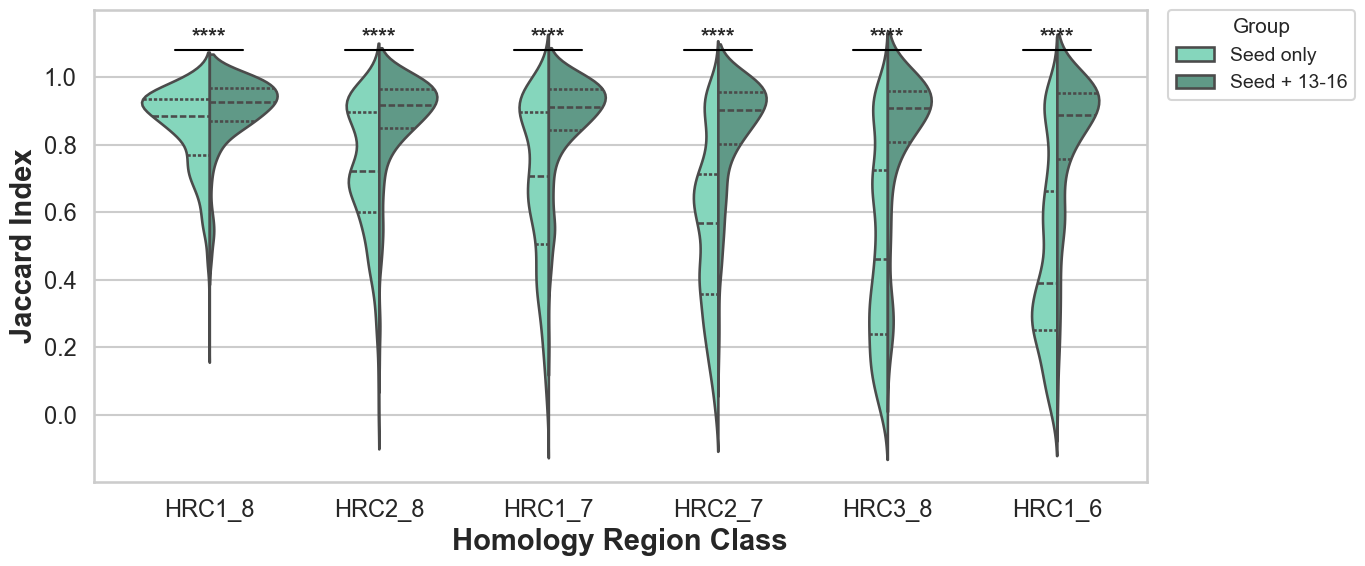

In [19]:
sns.set(style="whitegrid", context="talk")
palette_dict = {
    "Seed only": "#78e3c1",     
    "Seed + 13-16": "#56a38a"     
}

plt.figure(figsize=(14, 6))
ax = sns.violinplot(
    data=melted_13_16,
    x="Family",
    y="Jaccard",
    hue="Group",
    split=True,
    inner="quartile",
    palette=palette_dict,
)

families = sorted(melted_13_16["Family"].unique())
test_results = []

for i, fam in enumerate(families):
    sub_df = melted_13_16[melted_13_16["Family"] == fam]
    g1 = sub_df[sub_df["Group"] == "Seed only"]["Jaccard"]
    g2 = sub_df[sub_df["Group"] == "Seed + 13-16"]["Jaccard"]

    if len(g1) == 0 or len(g2) == 0:
        continue

    stat, p_value = mannwhitneyu(g1, g2, alternative="two-sided")
    stars = pval_to_stars(p_value)

    test_results.append({
        "Family": fam,
        "n Seed only": len(g1),
        "n Seed + 13-16": len(g2),
        "Median Seed only": g1.median(),
        "Median Seed + 13-16": g2.median(),
        "p-value": p_value,
        "Significance": stars
    })

    y_max = melted_13_16["Jaccard"].max() + 0.08
    x1, x2 = i - 0.2, i + 0.2
    plt.plot([x1, x2], [y_max, y_max], color='black', linewidth=1.5)
    plt.text((x1 + x2) / 2, y_max + 0.01, stars, ha='center', va='bottom', fontsize=16, fontweight="bold")

plt.ylabel("Jaccard Index", fontsize=21, fontweight="bold")
plt.xlabel("Homology Region Class", fontsize=21, fontweight="bold")
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.ylim(-0.2, 1.2)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.legend(title="Group", title_fontsize=15, fontsize=14, loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()

save = input("Save plot as PNG? (yes/no): ").strip().lower()
if save == 'yes':
    plt.savefig("jaccard_violinplot_seed_vs_13_16withMann.png", dpi=300, bbox_inches='tight')
    print("Plot saved as jaccard_violinplot_seed_vs_13_16withMann.png")

plt.show()

In [ ]:
# Mann-Whitney U test

In [21]:
mw_results = []

family_cols = [col for col in df.columns if col.startswith("Family_")]

for fam_col in family_cols:
    fam_label = fam_col.replace("Family_", "HRC")
    
    fam_df = df[df[fam_col] == "Yes"].copy()
    
    if fam_df.empty:
        continue  
    
    fam_df["Group"] = ["Seed+13_16" if p1 == p2 else "Seed only"
                       for p1, p2 in zip(fam_df["Pos13_16_1"], fam_df["Pos13_16_2"])]

    g1 = fam_df[fam_df["Group"] == "Seed only"]["Jaccard"]
    g2 = fam_df[fam_df["Group"] == "Seed+13_16"]["Jaccard"]

    if len(g1) == 0 or len(g2) == 0:
        continue 

    # Mann–Whitney U Test
    stat, p_value = mannwhitneyu(g1, g2, alternative="two-sided")

    mw_results.append({
        "Family": fam_label,
        "n Seed only": len(g1),
        "n Seed+13_16": len(g2),
        "Median Seed only": g1.median(),
        "Median Seed+13_16": g2.median(),
        "Mann-Whitney U": stat,
        "p-value": p_value
    })

mw_df = pd.DataFrame(mw_results)

display(mw_df)

,Family,n Seed only,n Seed+13_16,Median Seed only,Median Seed+13_16,Mann-Whitney U,p-value
0,HRC1_8,432,271,0.885270,0.925806,41211.0,3.751257e-11
1,HRC2_8,811,298,0.721925,0.917609,58396.5,7.884857e-40
2,HRC1_7,802,304,0.706715,0.913621,58791.0,2.040455e-40
3,HRC2_7,1919,346,0.567568,0.903047,102803.5,4.156959e-93
4,HRC3_8,1629,333,0.462963,0.909091,96717.0,1.273324e-76
5,HRC1_6,1888,359,0.391855,0.888889,110835.5,4.385986e-91


In [ ]:
# Correlation between number of 13-16 base matches and function - Pearson

In [23]:
def count_matching_bases(seq1, seq2):
    return sum(a == b for a, b in zip(seq1, seq2)) if pd.notnull(seq1) and pd.notnull(seq2) else None

In [25]:
correlation_results = []

family_cols = [col for col in df.columns if col.startswith("Family_")]

for fam_col in family_cols:
    fam_label = fam_col.replace("Family_", "HRC")

    fam_df = df[df[fam_col] == "Yes"].copy()

    if fam_df.empty:
        continue

    # Compute number of base matches at positions 13–16
    fam_df["13-16 Match Count"] = [
        count_matching_bases(p1, p2)
        for p1, p2 in zip(fam_df["Pos13_16_1"], fam_df["Pos13_16_2"])
    ]

    valid = fam_df.dropna(subset=["13-16 Match Count", "Jaccard"])
    
    if len(valid) < 10:
        continue  

    # Compute Pearson correlation
    r, p = pearsonr(valid["13-16 Match Count"], valid["Jaccard"])

    correlation_results.append({
        "Family": fam_label,
        "n Pairs": len(valid),
        "Pearson r": round(r, 3),
        "p-value": p
    })


correlation_df = pd.DataFrame(correlation_results)
display(correlation_df.sort_values("Family"))

,Family,n Pairs,Pearson r,p-value
5,HRC1_6,2247,0.552,2.090678e-179
2,HRC1_7,1106,0.549,3.779684e-88
0,HRC1_8,703,0.387,1.561517e-26
3,HRC2_7,2265,0.536,8.045283e-169
1,HRC2_8,1109,0.511,8.951823e-75
4,HRC3_8,1962,0.520,2.698595e-136


Save plot as PNG? (yes/no):  yes


Plot saved as jaccard_scatterplot_match13-16.png


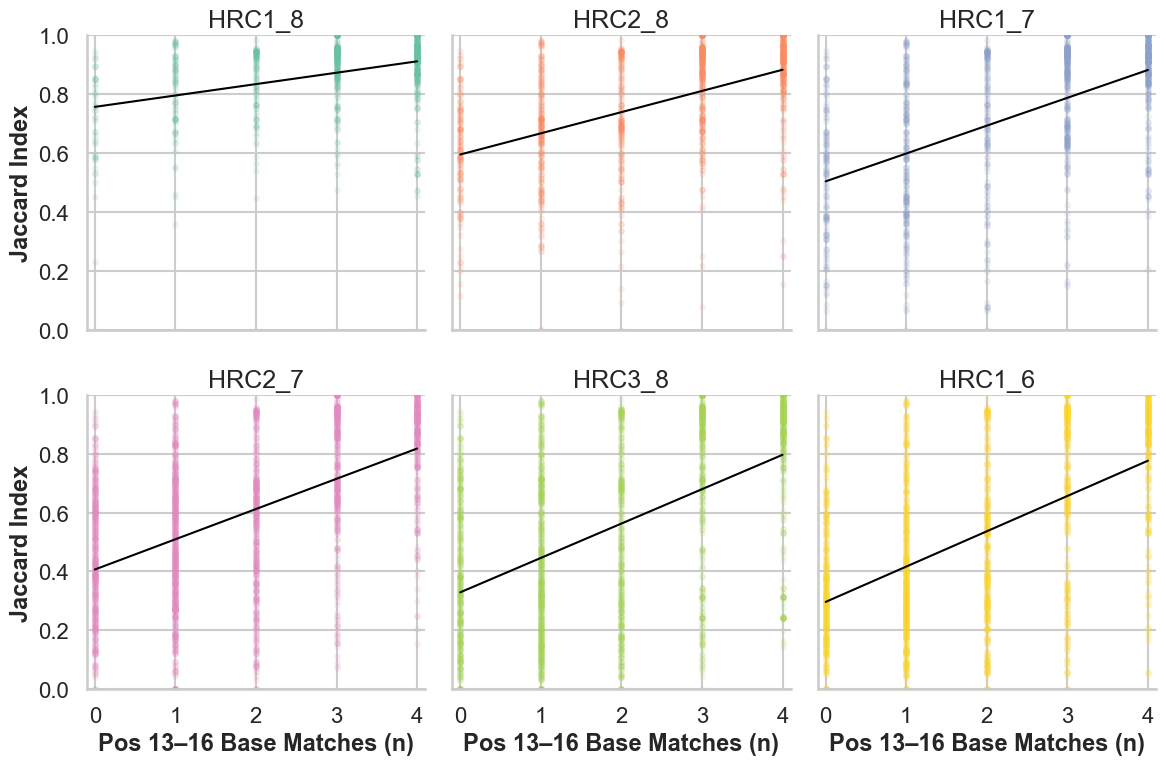

In [31]:
plot_records = []

for fam_col in [col for col in df.columns if col.startswith("Family_")]:
    fam_label = fam_col.replace("Family_", "HRC")
    fam_df = df[df[fam_col] == "Yes"].copy()

    if fam_df.empty:
        continue

    fam_df["Family"] = fam_label
    fam_df["13-16 Match Count"] = [
        sum(a == b for a, b in zip(p1, p2)) if pd.notnull(p1) and pd.notnull(p2) else None
        for p1, p2 in zip(fam_df["Pos13_16_1"], fam_df["Pos13_16_2"])
    ]

    plot_records.append(fam_df[["Family", "13-16 Match Count", "Jaccard"]])

full_plot_df = pd.concat(plot_records, ignore_index=True).dropna()

sns.set(style="whitegrid", context="talk")

# Linear plot with a regression line (OLS linear model as default)
g = sns.lmplot(
    data=full_plot_df,
    x="13-16 Match Count",
    y="Jaccard",
    col="Family",
    hue="Family",
    col_wrap=3,
    height=4,
    aspect=1,
    scatter_kws={"alpha": 0.1, "s": 15},
    line_kws={"color": "black", "linewidth": 1.5},
    palette="Set2",
    ci=None
)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("13–16 Base Matches", "Jaccard Index")
g.set(ylim=(0, 1), xlim=(-0.1, 4.1))
for ax in g.axes.flatten():
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_xlabel("Pos 13–16 Base Matches (n)", fontsize=17, fontweight="bold")
    ax.set_ylabel("Jaccard Index", fontsize=17, fontweight="bold")

plt.subplots_adjust(top=0.9)

plt.tight_layout()

save = input("Save plot as PNG? (yes/no): ").strip().lower()
if save == 'yes':
    plt.savefig("jaccard_scatterplot_match13-16.png", dpi=300, bbox_inches='tight')
    print("Plot saved as jaccard_scatterplot_match13-16.png")

plt.show()

In [ ]:
# Numerical summary of the linear model

In [33]:
families = full_plot_df["Family"].unique()

scatter_regression_results = []

for fam in families:
    fam_df = full_plot_df[full_plot_df["Family"] == fam]
    X = fam_df["13-16 Match Count"]
    y = fam_df["Jaccard"]
    X_const = sm.add_constant(X)

    model = sm.OLS(y, X_const).fit()

    scatter_regression_results.append({
        "Family": fam,
        "Slope": model.params["13-16 Match Count"],
        "Intercept": model.params["const"],
        "R²": model.rsquared,
        "p-value": model.pvalues["13-16 Match Count"]
    })

In [35]:
scatter_regression_df = pd.DataFrame(scatter_regression_results).sort_values(by="R²", ascending=False)
display(scatter_regression_df)

,Family,Slope,Intercept,R²,p-value
5,HRC1_6,0.120000,0.296329,0.304703,2.090678e-179
2,HRC1_7,0.094644,0.503681,0.301623,3.779684e-88
3,HRC2_7,0.102793,0.406451,0.287522,8.045283e-169
4,HRC3_8,0.116829,0.328932,0.270282,2.698595e-136
1,HRC2_8,0.072026,0.594906,0.261040,8.951823e-75
0,HRC1_8,0.038692,0.756872,0.149752,1.561517e-26


In [ ]:
# Statistical test to compare linear regression slopes between families - Wald t-test

In [37]:
regression_data = full_plot_df.dropna(subset=["13-16 Match Count", "Jaccard", "Family"]).copy()
regression_data = regression_data.rename(columns={"13-16 Match Count": "Match_13_16_Count"})

model = smf.ols("Jaccard ~ Match_13_16_Count * Family", data=regression_data).fit()

families = sorted(regression_data["Family"].unique())
ref_family = families[0]

params = model.params
slopes = {}

for fam in families:
    if fam == ref_family:
        slope = params["Match_13_16_Count"]
    else:
        interaction_term = f"Match_13_16_Count:Family[T.{fam}]"
        slope = params["Match_13_16_Count"] + params.get(interaction_term, 0)
    slopes[fam] = slope

results = []

for fam1, fam2 in combinations(families, 2):
    contrast_vector = pd.Series(0, index=model.params.index)

    if fam1 == ref_family:
        contrast_vector["Match_13_16_Count"] += 1
    else:
        contrast_vector["Match_13_16_Count"] += 1
        contrast_vector[f"Match_13_16_Count:Family[T.{fam1}]"] += 1

    if fam2 == ref_family:
        contrast_vector["Match_13_16_Count"] -= 1
    else:
        contrast_vector["Match_13_16_Count"] -= 1
        contrast_vector[f"Match_13_16_Count:Family[T.{fam2}]"] -= 1

    # Perform t-test on the contrast
    test_result = model.t_test(contrast_vector.values)
    t_stat = test_result.tvalue.item()
    p_val = test_result.pvalue.item()

    results.append({
        "Family A": fam1,
        "Family B": fam2,
        "Slope A": slopes[fam1],
        "Slope B": slopes[fam2],
        "Difference": slopes[fam1] - slopes[fam2],
        "t-stat": t_stat,
        "p-value": p_val
    })

pairwise_slope_df = pd.DataFrame(results)
pairwise_slope_df["FDR-adjusted p"] = multipletests(pairwise_slope_df["p-value"], method="fdr_bh")[1]

display(pairwise_slope_df.sort_values("FDR-adjusted p"))

,Family A,Family B,Slope A,Slope B,Difference,t-stat,p-value,FDR-adjusted p
1,HRC1_6,HRC1_8,0.120000,0.038692,0.081308,10.605246,3.959652e-26,5.939478e-25
11,HRC1_8,HRC3_8,0.038692,0.116829,-0.078138,-10.054148,1.160452e-23,8.703386e-23
9,HRC1_8,HRC2_7,0.038692,0.102793,-0.064101,-8.361077,7.101023e-17,3.550511e-16
3,HRC1_6,HRC2_8,0.120000,0.072026,0.047974,8.049990,9.287605e-16,3.482852e-15
14,HRC2_8,HRC3_8,0.072026,0.116829,-0.044803,-7.352221,2.112673e-13,6.338018e-13
5,HRC1_7,HRC1_8,0.094644,0.038692,0.055952,6.667464,2.749355e-11,6.873386e-11
12,HRC2_7,HRC2_8,0.102793,0.072026,0.030767,5.162845,2.482119e-07,5.318826e-07
0,HRC1_6,HRC1_7,0.120000,0.094644,0.025356,4.260681,2.057956e-05,3.858667e-05
10,HRC1_8,HRC2_8,0.038692,0.072026,-0.033334,-3.969488,7.256438e-05,1.209406e-04
8,HRC1_7,HRC3_8,0.094644,0.116829,-0.022185,-3.645492,2.683239e-04,4.024859e-04


In [ ]:
# Heatmap of Wald t-test comparisons

C:\Users\moris\AppData\Local\Temp\ipykernel_17992\992589375.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  score_matrix = star_matrix.replace(star_to_score)


Save plot as PNG? (yes/no):  yes


Plot saved as Heatmap_Pairwise_Slope_Diff.png


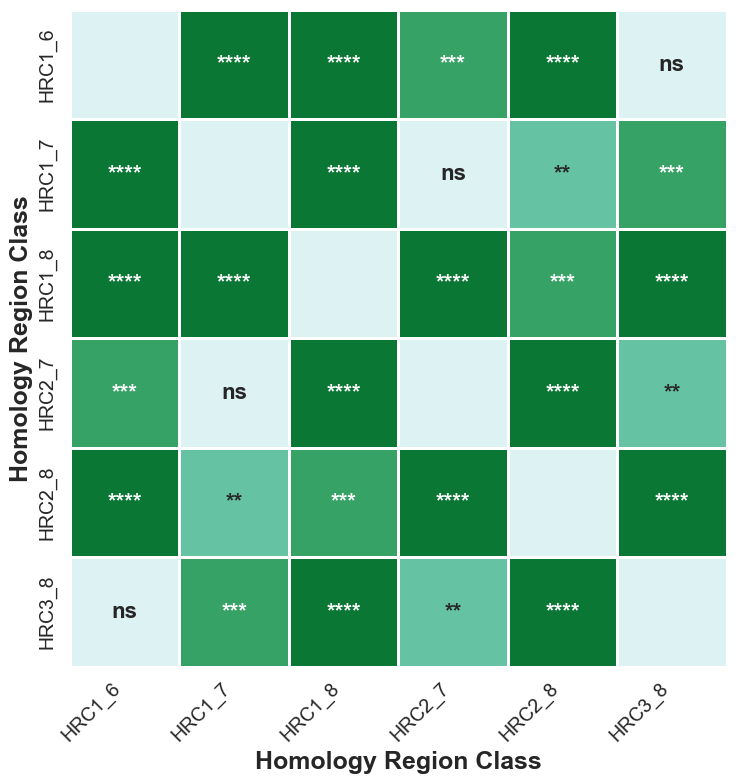

In [39]:
families = sorted(set(pairwise_slope_df["Family A"]) | set(pairwise_slope_df["Family B"]))

star_matrix = pd.DataFrame("", index=families, columns=families)

for _, row in pairwise_slope_df.iterrows():
    fam_a = row["Family A"]
    fam_b = row["Family B"]
    p_adj = row["FDR-adjusted p"]
    stars = pval_to_stars(p_adj)
    star_matrix.loc[fam_a, fam_b] = stars
    star_matrix.loc[fam_b, fam_a] = stars  # make symmetric

star_to_score = {"ns": 0, "*": 1, "**": 2, "***": 3, "****": 4}
star_matrix.replace("", "ns", inplace=True)
score_matrix = star_matrix.replace(star_to_score)

annot_display = star_matrix.copy()
for i in annot_display.index:
    annot_display.loc[i, i] = ""

pastel_green = sns.color_palette("BuGn", n_colors=5)

plt.figure(figsize=(10, 8))
sns.set(style="white")

sns.heatmap(
    score_matrix,
    annot=annot_display,
    fmt='',
    cmap=pastel_green,
    linewidths=1,
    linecolor='white',
    square=True,
    cbar=False,
    annot_kws={"fontsize": 16, "weight": "bold"}
)

plt.xlabel("Homology Region Class", fontsize=18, fontweight='bold')
plt.ylabel("Homology Region Class", fontsize=18, fontweight='bold')
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14)

plt.tight_layout()

save = input("Save plot as PNG? (yes/no): ").strip().lower()
if save == 'yes':
    plt.savefig("Heatmap_Pairwise_Slope_Diff.png", dpi=300, bbox_inches='tight')
    print("Plot saved as Heatmap_Pairwise_Slope_Diff.png")

plt.show()